Generate list of samples to use for QA checks for temporal consistency

In [1]:
%load_ext lab_black

In [2]:
from datetime import timedelta

from cloudpathlib import AnyPath
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from shapely.geometry import Point

from cyano.data.utils import add_unique_identifier

In [3]:
EXPERIMENT_DIR = Path("../experiments/results/temporal_qa_checks/")
EXPERIMENT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
df = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/test.csv"
    )
)
df["date"] = pd.to_datetime(df.date)
df.head(3)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
0,aabn,California Environmental Data Exchange Network,west,36.559700,-121.51000,2016-08-31,5.867500e+06,4,3512.0,15.584939
1,aair,California Environmental Data Exchange Network,west,33.042600,-117.07600,2014-11-01,2.769000e+06,4,195.0,14.833997
2,aajw,US Army Corps of Engineers,northeast,40.703968,-80.29305,2015-08-26,2.451087e+03,1,0.0,7.804695


### Select subset of samples

In [5]:
# subset to points in water bodies
subset = df[df.distance_to_water_m == 0]
print(f"Narrowed to {subset.shape[0]:,} samples in water")

# only have max 1 example at each location
subset = subset.sample(frac=1, random_state=3)
subset = subset.groupby(["latitude", "longitude"], as_index=False).first()
print(f"Narrowed to {subset.shape[0]:,} unique locations")

# take some from each region
subset = pd.concat(
    [
        subset[subset.region == region].sample(n=7, random_state=2)
        for region in subset.region.unique()
    ]
)
subset = add_unique_identifier(subset)

subset.head(3)

Narrowed to 2,680 samples in water
Narrowed to 850 unique locations


,latitude,longitude,uid,data_provider,region,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
62e60b0aaa2e7df569988355e48a40b0,36.50000,-79.066285,nmdb,N.C. Division of Water Resources N.C. Departme...,south,2019-05-28,16011.0,1,0.0,9.681094
e4585bbce572a9be6aee1411be3c1dbe,39.49277,-79.794220,ihyj,EPA National Aquatic Research Survey,south,2017-08-23,296870.0,3,0.0,12.601053
f08649ed7d39f6ca06a6f97336a75b45,36.50000,-79.067225,ryeu,N.C. Division of Water Resources N.C. Departme...,south,2019-09-19,1452.0,1,0.0,7.281386


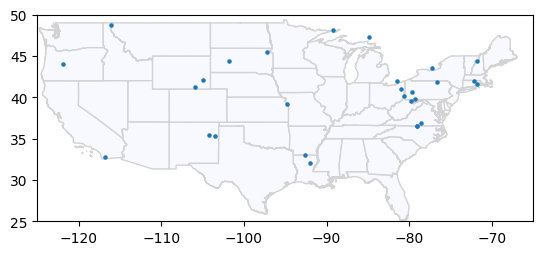

In [6]:
# see on a map where these samples are
_, ax = plt.subplots()

STATES_SHAPEFILE = gpd.GeoDataFrame.from_file(
    "../../competition-nasa-cyanobacteria/data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
)
STATES_SHAPEFILE.plot(color="ghostwhite", edgecolor="lightgray", ax=ax)

geometry = [Point(xy) for xy in zip(subset.longitude, subset.latitude)]
gdf = gpd.GeoDataFrame(subset, geometry=geometry)
gdf.plot(ax=ax, markersize=5)

ax.set_xlim([-125, -65])
ax.set_ylim([25, 50])
plt.show()

In [7]:
subset.severity.value_counts().sort_index()

severity
1    16
2     5
3     7
Name: count, dtype: int64

### Add temporal checks

Add additional rows around each sample spanning 4 weeks

In [8]:
predict_df = []

for sample in subset.itertuples():
    predict_df.append(
        pd.DataFrame(
            {
                "latitude": sample.latitude,
                "longitude": sample.longitude,
                # 4 week range for each sample
                # 7 days between samples
                "date": pd.date_range(
                    start=sample.date - timedelta(days=14),
                    end=sample.date + timedelta(days=14),
                    freq="7d",
                    inclusive="both",
                ),
                "region": sample.region,
                "original_sample_id": sample.Index,
            }
        )
    )

predict_df = pd.concat(predict_df)
predict_df.shape

(140, 5)

In [9]:
predict_df

,latitude,longitude,date,region,original_sample_id
0,36.5000,-79.066285,2019-05-14,south,62e60b0aaa2e7df569988355e48a40b0
1,36.5000,-79.066285,2019-05-21,south,62e60b0aaa2e7df569988355e48a40b0
2,36.5000,-79.066285,2019-05-28,south,62e60b0aaa2e7df569988355e48a40b0
3,36.5000,-79.066285,2019-06-04,south,62e60b0aaa2e7df569988355e48a40b0
4,36.5000,-79.066285,2019-06-11,south,62e60b0aaa2e7df569988355e48a40b0
...,...,...,...,...,...
0,41.9928,-72.131000,2018-07-05,northeast,cf5689d0a6ed3800382f102498896a91
1,41.9928,-72.131000,2018-07-12,northeast,cf5689d0a6ed3800382f102498896a91
2,41.9928,-72.131000,2018-07-19,northeast,cf5689d0a6ed3800382f102498896a91
3,41.9928,-72.131000,2018-07-26,northeast,cf5689d0a6ed3800382f102498896a91


In [10]:
save_to = EXPERIMENT_DIR / "samples.csv"
save_to.parent.mkdir(exist_ok=True, parents=True)

predict_df.to_csv(save_to, index=False)

print(f"Samples for prediction saved to {save_to}")

Samples for prediction saved to ../experiments/results/temporal_qa_checks/samples.csv


To generate predictions:

`python cyano/cli.py predict experiments/results/temporal_qa_checks/samples.csv --output-path experiments/results/temporal_qa_checks/preds.csv`